# Dependências

In [1]:
print('Install dependencies...')
print('Update apt. ')
!sudo apt update > apt_update.log
print('Install software-properties-common.')
!sudo apt install software-properties-common > spc.log
print('Add ppa-git-core repository.')
!sudo add-apt-repository -y ppa:git-core/ppa > ppa_git_core.log
print('Install the latest version of git.')
!sudo apt install -y git > install_git.log
!git --version > git_version.log
print('Install pydriller')
!pip3 install pydriller > install_pydriller.log
!pip3 list | grep PyDriller > versao_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
!pip install sqlite3 > install_sqlite.log
!sudo apt install sqlite3 > install_sqlite3.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install dependencies...
Update apt. 


Install software-properties-common.


Add ppa-git-core repository.
Install the latest version of git.


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Install pydriller
Install gitpython.
All depenpencies installed!
Details in install.log


# Apoio (Classes)

In [17]:
import subprocess
import pydriller
import tqdm
import sqlite3
import os
import re

DATABASE_NAME = "commits_db.db"
os.environ['DATABASE_NAME'] = DATABASE_NAME

class Commit:
  def __init__(self,hash, message, list_modified_files=None, list_name_modified_files=None, dict_source_code=None):
    self.hash = hash
    self.message = message
    self.list_modified_files = list_modified_files
    self.list_name_modified_files = list_name_modified_files
    self.dict_source_code = dict_source_code

  def add_modified_files(self, modified_file):
    self.list_modified_files.append(modified_file)

  def get_modifeid_files(self) -> list:
    return self.list_modified_files

  def add_source_code(self, filename, source_code):
    self.dict_source_code[filename] = source_code

  def get_dict_source_code(self) -> dict:
    return self.dict_source_code

  def update_dict_source_code(self, dict_source_code):
    self.dict_source_code = dict_source_code

  def update_list_modified_files(self, list_modified_files):
    self.list_modified_files = list_modified_files

  def update_list_name_modified_files(self, list_name_modified_files):
    self.list_name_modified_files = list_name_modified_files

  def get_name_modified_files(self) -> list:
    return self.list_name_modified_files

  def __str__(self):
    return f'Hash: {self.hash}, message: {self.message}'

class CommitsUtil:
    def __init__(self, repository_path):
        self.repository_path = repository_path

    def get_total_commit_count(self) -> int:
        command = ["git", "rev-list", "--count", "HEAD"]
        result = subprocess.run(command, cwd=self.repository_path, stdout=subprocess.PIPE, text=True)
        total_commit_count = int(result.stdout.strip())
        return total_commit_count

    def extract_commits_info(self):
        total_commit_count = self.get_total_commit_count()
        print(f'Extracting commit information')
        total_commits = total_commit_count
        my_commits = []
        i = 0

        iterable_commits = tqdm.tqdm(pydriller.Repository(self.repository_path).traverse_commits(), total=total_commits)

        for commit in iterable_commits:
            current_commit = Commit(hash=commit.hash, message=commit.msg, list_modified_files=commit.modified_files)
            list_name_modified_files = []
            dict_source_code_files = {}
            for m in commit.modified_files:
                list_name_modified_files.append(m.filename)
                dict_source_code_files[m.filename] = m.source_code
            # Update the list of modified file names
            current_commit.update_list_name_modified_files(list_name_modified_files=list_name_modified_files)
            # Update the dictionary of source code for modified files
            current_commit.update_dict_source_code(dict_source_code=dict_source_code_files)
            my_commits.append(current_commit)
            percentage = (i + 1) / total_commits * 100
            iterable_commits.set_description(f"Progress Commit Analysis")
            i += 1

        return my_commits

    def extract_todo_messages(self, java_file_content):
        todo_messages = re.findall(r"TODO.*", java_file_content)
        return todo_messages

class CommitsDatabase:
    def __init__(self, database_name):
        self.database_name = database_name
        self.create_tables()

    def create_tables(self):
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Commits (
                id INTEGER PRIMARY KEY,
                project TEXT,
                hash TEXT,
                message TEXT,
                modified_files TEXT
            )
        ''')

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS SourceCodes (
                id INTEGER PRIMARY KEY,
                hash TEXT,
                filename TEXT,
                source_code TEXT,
                list_of_todo_msg TEXT
            )
        ''')

        self.conn.commit()

    def insert_in_table_commits(self, project, hash, message, modified_files):
        values = (None, project, hash, message, modified_files)
        self.cursor.execute('''
            INSERT INTO Commits
            (id, project, hash, message, modified_files)
            VALUES (?, ?, ?, ?, ?)
        ''', values)

        self.conn.commit()

    def insert_in_table_source_codes(self, hash, filename, source_code, list_of_todo_msg):
        values = (None, hash, filename, source_code, list_of_todo_msg)
        self.cursor.execute('''
            INSERT INTO SourceCodes
            (id, hash, filename, source_code, list_of_todo_msg)
            VALUES (?, ?, ?, ?, ?)
        ''', values)

        self.conn.commit()

    def show_content(self, table):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()
        for row in rows:
            print(row)

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def close_connection(self):
        self.conn.close()

# Extrai commits (Cassandra)

In [5]:
!git clone https://github.com/apache/cassandra.git

Cloning into 'cassandra'...
remote: Enumerating objects: 399110, done.
remote: Counting objects: 100% (2179/2179), done.
remote: Compressing objects: 100% (983/983), done.
remote: Total 399110 (delta 1004), reused 1836 (delta 849), pack-reused 396931
Receiving objects: 100% (399110/399110), 394.75 MiB | 24.36 MiB/s, done.
Resolving deltas: 100% (232971/232971), done.


In [6]:
# Mostra todos os commits
!cd cassandra && git log --pretty="%H;%ai;%s" > all_commits_full.txt
!cd cassandra && git log --pretty="%H %s" > all_commits_msg.txt
!echo "10 primeiros commits all_commits_msg.txt"
!cd cassandra && head all_commits_msg.txt
!echo "..."

# Total de commits registrados entre as versões cassandra-3.0.0...cassandra-3.11.11
!echo "Total de commits registrados "
!cd cassandra && cat all_commits_msg.txt | wc -l

10 primeiros commits all_commits_msg.txt
3ebd09262ba2462e97b012838b19c6f3231d4190 Merge branch 'cassandra-5.0' into trunk
871e42cf97507f4536e4a4873cf4f8e9a68ff1a3 Merge branch 'cassandra-4.1' into cassandra-5.0
8bfe0e5878c64ed25591aae50643187bc8ab7241 InstanceClassLoader leak in 5.0/trunk
1087d88303754d52124c990b8d82640a729c8b9f Merge branch 'cassandra-5.0' into trunk
dcfacad116dc3e7fa63aff358b8edd4b5ac17e2f ninja fix unused import
f7472774f4c4e909af4a8a75c85ac5df71c71b63 Merge branch 'cassandra-5.0' into trunk
1ac31a64a9d02372f59938592aff283ed7c0b438 Merge branch 'cassandra-4.1' into cassandra-5.0
b8209a06fbad6d5dda239f06ea889a4a89427296 Merge branch 'cassandra-4.0' into cassandra-4.1
edde699a062701345133b6f0648a744b426a6f94 Merge branch 'cassandra-3.11' into cassandra-4.0
edf22ed776d36112c165c6858dd4866b754ecf34 Revert 18543 but retain properties
...
Total de commits registrados 
29166


In [7]:
# Dados do 1o commit e do ultimo commit
!head /content/cassandra/all_commits_full.txt -n 1
!tail /content/cassandra/all_commits_full.txt -n 1

3ebd09262ba2462e97b012838b19c6f3231d4190;2023-09-15 14:12:28 -0600;Merge branch 'cassandra-5.0' into trunk
1f91e99223b0d1b7ed8390400d4a06ac08e4aa85;2009-03-02 07:57:22 +0000;git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@749218 13f79535-47bb-0310-9956-ffa450edef68


# Coleta commits para um manipulador de commits

In [10]:
repo_path = "cassandra"  # Replace with your repository path
commit_util = CommitsUtil(repo_path)
all_commits_from_cassandra = commit_util.extract_commits_info()

Extracting commit information


Progress Commit Analysis: 100%|██████████| 29166/29166 [12:37<00:00, 38.50it/s]


In [12]:
def convert_files_list_to_string(list_of_files):
  concatenated_string = ""
  for file in list_of_files:
    concatenated_string += file + ", "
  concatenated_string = concatenated_string[:-2]

  return concatenated_string

# Salva as informações de commits em um banco (SQLite)

Guarda as informações em duas tabelas: Commits e SourceCodes

In [19]:
db = CommitsDatabase("commits_db.db")
print('Popula banco de dados commits_db com as informações dos Commits.')
print(f'Extrai informações dos commits')
total_commits = len(all_commits_from_cassandra)
i = 0

iterable_extrai_todos_commits = tqdm.tqdm(all_commits_from_cassandra, total=total_commits)

lista_todo_messages = []

for each in iterable_extrai_todos_commits:
  hash = each.hash
  lista_arquivos_modificados = each.get_name_modified_files()
  dict_source_code_by_file = each.get_dict_source_code()
  db.insert_in_table_commits(project='CASSANDRA', hash=hash, message=each.message, modified_files=convert_files_list_to_string(lista_arquivos_modificados))
  for arquivo_modificado in lista_arquivos_modificados:
    filename = arquivo_modificado
    if filename is not None:
      java_file_content = dict_source_code_by_file[arquivo_modificado]
      if java_file_content is not None:
        todo_msg = commit_util.extract_todo_messages(java_file_content)
        if todo_msg is not None:
          lista_todo_messages.append(todo_msg)
      db.insert_in_table_source_codes(hash=hash, filename=filename, source_code=java_file_content, list_of_todo_msg=convert_files_list_to_string(todo_msg))
  percentage = (i + 1) / total_commits * 100
  iterable_extrai_todos_commits.set_description(f"Progress Todo Analysis")
  i += 1
db.close_connection()

Popula banco de dados commits_db com as informações dos Commits.
Extrai informações dos commits


Progress Todo Analysis: 100%|██████████| 29166/29166 [25:29<00:00, 19.08it/s]


## Exemplo de mensagens TODO salvas

In [20]:
len(lista_todo_messages)

94628

In [30]:
for i,each in enumerate(lista_todo_messages):
    if len(each)>0:
      print(i,each)
    if i==500:
      break

64 ['TODO: Once bind variables are supported, the get() will extract']
107 ['TODO: These are the various column types. Hard coded for now. */\r']
109 ['TODO\r', 'TODO: Take care of the comments later. */\r']
111 ['TODO: Remove this to not process Hints */\r']
123 ['TODO : fix the hack we need to make sure the data is written on the other end.\r']
128 ['TODO Auto-generated method stub\r', 'TODO Auto-generated method stub\r']
142 ['TODO : Delete is NOT correct as we do not know \r']
149 ['TODO : For super columns we need to re-visit this issue.\r']
150 ['TODO Auto-generated method stub\r']
151 ['TODO Auto-generated method stub\r']
183 ['TODO: Debug only */\r', 'TODO: Remove later. */\r']
195 ['TODO: this is name sorted - but eventually this should be sorted by the same criteria as the col index\r']
202 ['TODO : Add checks for large data\r']
204 ['TODO Auto-generated method stub\r']
231 ['TODO: make this parameter dynamic somehow.  Not sure if config is appropriate.\r']
240 ['TODO: get TC

In [33]:
!ls -liath

total 3.9G
2752518 drwxr-xr-x  1 root root 4.0K Sep 17 02:46 .
 401667 -rw-r--r--  1 root root 3.9G Sep 17 02:46 commits_db.db
 393682 drwxr-xr-x 19 root root 4.0K Sep 17 01:33 cassandra
 393360 -rw-r--r--  1 root root 6.9K Sep 17 01:28 install.log
 393354 -rw-r--r--  1 root root  341 Sep 17 01:28 install_gitpython.log
 393249 -rw-r--r--  1 root root   39 Sep 17 01:28 versao_pydriller.log
 393339 -rw-r--r--  1 root root 1.4K Sep 17 01:28 install_pydriller.log
 393338 -rw-r--r--  1 root root   19 Sep 17 01:28 git_version.log
 393335 -rw-r--r--  1 root root 1.9K Sep 17 01:28 install_git.log
 393313 -rw-r--r--  1 root root 1.7K Sep 17 01:27 ppa_git_core.log
 393293 -rw-r--r--  1 root root  216 Sep 17 01:27 spc.log
 393277 -rw-r--r--  1 root root 1.5K Sep 17 01:27 apt_update.log
 393230 drwxr-xr-x  1 root root 4.0K Sep 17 01:26 ..
2752519 drwxr-xr-x  1 root root 4.0K Sep 14 13:23 sample_data
1703943 drwxr-xr-x  4 root root 4.0K Sep 14 13:22 .config


# Manipula o banco de dados salvo (commits_db.db)

O arquivo do banco ficou em 3.5 GBbytes

In [82]:
class DatabaseUtils:
    def __init__(self, database_name):
        self.database_name = database_name
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def show_n_lines_from_files(self, table, list_of_files, n=None):
        lista_resultado = []
        tuple_of_files = tuple(list_of_files)
        query = f"SELECT hash, filename, list_of_todo_msg FROM {table} where filename in {tuple_of_files}"
        print(query)
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            lista_resultado.append(row)
            if n is not None:
              if i == n:
                break
        return lista_resultado

    def show_n_lines_from_messages(self,table, list_of_files, n=None):
        lista_resultado = []
        tuple_of_files = tuple(list_of_files)
        # id, project, hash, message, modified_files
        query = f"SELECT hash, message, modified_files FROM {table} where modified_files in {tuple_of_files}"
        print(query)
        self.cursor.execute(query)
        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            lista_resultado.append(row)
            if n is not None:
              if i == n:
                break
        return lista_resultado


    def close_connection(self):
        self.conn.close()

## Recupera informações de mensagens salvas nos commits

apenas os arquivos críticos identificados pelo ATDCodeAnalyzer

### Todos (filtrado por arquivos criticos)

In [63]:
db = DatabaseUtils("commits_db.db")
arquivos_criticos = ['StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'Config.java', 'CassandraDaemon.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java']
lista_resultado = db.show_n_lines_from_files(table='SourceCodes', list_of_files=arquivos_criticos)
db.close_connection()

SELECT hash, filename, list_of_todo_msg FROM SourceCodes where filename in ('StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'Config.java', 'CassandraDaemon.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java')


In [64]:
len(lista_resultado)

7160

In [114]:
# Mostra um fragmento do resultado dos todos filtrados
for i, item_todos in enumerate(lista_resultado):
  print(item_todos)
  if i == 30:
    break

('1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'DatabaseDescriptor.java', '')
('1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'ColumnFamilyStore.java', 'TODO\r, TODO: Take care of the comments later. */\r')
('1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'MessagingService.java', 'TODO: make this parameter dynamic somehow.  Not sure if config is appropriate.\r')
('1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'StorageProxy.java', 'TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception \r, TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception if we do not have N nodes\r, TODO: throw a thrift exception if we do not have N nodes\r')
('1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'StorageService.java', 'TODO: This is a null pointer exception if JobTracker

### Gera um arquivo texto de "TODO" para os arquivos críticos

In [117]:
# constante para acessar conteudo de lista_resultado
HASH_SOURCE=0
FILENAME_SOURCE=1
TODOS_SOURCE=2

dict_arquivo_todos_msg = {}
for arquivo in arquivos_criticos:
  texto_todos_msg = ""
  for each_item in lista_resultado:
    if each_item[FILENAME_SOURCE]==arquivo:
      texto_todos_msg = texto_todos_msg + each_item[TODOS_SOURCE]
  dict_arquivo_todos_msg[arquivo] = texto_todos_msg

# filtra apenas os todos do 'StorageService.java'
todos_storageservice = dict_arquivo_todos_msg['StorageService.java']
print(todos_storageservice)

TODO: remove later */TODO: remove later */TODO: remove later */TODO: remove later */TODO: remove later */TODO: remove later */TODO: remove later */TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */, TODO:TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO: used for testing */TODO

### Mensagens salvas nos commits (filtrado por arquivos criticos)

In [83]:
db = DatabaseUtils("commits_db.db")
lista_resultado2 = db.show_n_lines_from_messages(table='Commits', list_of_files=arquivos_criticos)
db.close_connection()

SELECT hash, message, modified_files FROM Commits where modified_files in ('StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'SSTableReader.java', 'Config.java', 'CassandraDaemon.java', 'SelectStatement.java', 'SinglePartitionReadCommand.java', 'NodeProbe.java', 'MessagingService.java')


In [84]:
len(lista_resultado2)

581

In [115]:
# Mostra um fragmento do resultado dos todos filtrados
for i, item_msg in enumerate(lista_resultado2):
  print(item_msg)
  if i == 30:
    break

('76f33027535a192ab2d76ac1f01a5a8829c845af', 'add error checking of CF names for people migrating old-style configurations\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@759003 13f79535-47bb-0310-9956-ffa450edef68', 'DatabaseDescriptor.java')
('4a6f633ec21ed7e9ec9e0dbfbb963836f1fb2290', 'r/m unused config setting mapOutputDirectories\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@760967 13f79535-47bb-0310-9956-ffa450edef68', 'DatabaseDescriptor.java')
('a5b14b721944b189c391e9688d4243302458b2ab', 'jsvc actually wants the method to be named init, not load (contrary to what their docs state in at least one place)\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@761346 13f79535-47bb-0310-9956-ffa450edef68', 'CassandraDaemon.java')
('c386d36a69d3abf744d4c3b1d070168f56900080', 'pass engine options to the constructor\n\ngit-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@761411 13f79535-47bb-0310

### Gera um arquivo texto de "Mensagens de commits" para os arquivos críticos

In [90]:
HASH_MSG=0
MSG_MSG=1
FILENAME_MSG=2

In [93]:
lista_resultado2[100][HASH_MSG]

'e70502c094194fd41d69c1bf8356255a8783a21c'

In [92]:
lista_resultado2[100][MSG_MSG]

'avoid NPE when no keyspaces are defined in yaml. Patch by Sylvain Lebresne, reviewd by gdusbabek. CASSANDRA-1080\n\ngit-svn-id: https://svn.apache.org/repos/asf/cassandra/trunk@943566 13f79535-47bb-0310-9956-ffa450edef68'

In [91]:
lista_resultado2[100][FILENAME_MSG]

'DatabaseDescriptor.java'

In [94]:
dict_arquivo_msg = {}
for arquivo in arquivos_criticos:
  texto_msg = ""
  for each_item in lista_resultado2:
    if each_item[FILENAME_MSG]==arquivo:
      texto_msg = texto_msg + each_item[MSG_MSG]
  dict_arquivo_msg[arquivo] = texto_msg

In [107]:
txt_mensagens_storageservice = dict_arquivo_msg['StorageService.java']
print(txt_mensagens_storageservice)

replace one-shot lock w/ synchronized block.  patch by jbellis

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@822459 13f79535-47bb-0310-9956-ffa450edef68rename nodePicker -> replicationStrategy.
patch by jbellis; reviewed by Sandeep Tata for CASSANDRA-497

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@828028 13f79535-47bb-0310-9956-ffa450edef68fix misleading comment.  patch by jbellis for CASSANDRA-545

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@835873 13f79535-47bb-0310-9956-ffa450edef68Modify move function to get balanced token at bootstrap time if token given as a parameter was null.  patch by Jaakko Laine; reviewed by jbellis for CASSANDRA-574

git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@883405 13f79535-47bb-0310-9956-ffa450edef68add RING_DELAY sleep to startBootstrap.  patch by Jaakko Laine; reviewed by jbellis for CASSANDRA-575

git-svn-id: https://svn.apache.org/repos/asf/inc

# Testes de Nuvem de palavras (mensagens e TODO)

Usei o NLTK (Natural Language Toolkit) e worldcloud para mostrar as palavras mais frequêntes nas mensagens e nos TODOs


In [97]:
!pip install wordcloud

In [98]:
# essential libraries
import os
import pandas as pd
import numpy as np

# regular expression import
import re

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [99]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [103]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [100]:
# Funções de apoio
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

def stem(string):
    '''
    This function takes in a string and
    returns a string with words stemmed.
    '''
    # Create porter stemmer.
    ps = nltk.porter.PorterStemmer()

    # Use the stemmer to stem each word in the list of words we created by using split.
    stems = [ps.stem(word) for word in string.split()]

    # Join our lists of words into a string again and assign to a variable.
    string = ' '.join(stems)

    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)

    return string

def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')

    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)

    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()

    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]

    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)

    return string_without_stopwords

def clean(text):
    '''
    This function combines the above steps and added extra stop words to clean text
    '''
    return remove_stopwords(lemmatize(basic_clean(text)))

## Limpa os textos de mensagens e TODOs

In [109]:
texto_limpo_msg_storagesevice = clean(txt_mensagens_storageservice)
print(texto_limpo_msg_storagesevice)

replace oneshot lock w synchronized block patch jbellis gitsvnid httpssvnapacheorgreposasfincubatorcassandratrunk822459 13f7953547bb03109956ffa450edef68rename nodepicker replicationstrategy patch jbellis reviewed sandeep tata cassandra497 gitsvnid httpssvnapacheorgreposasfincubatorcassandratrunk828028 13f7953547bb03109956ffa450edef68fix misleading comment patch jbellis cassandra545 gitsvnid httpssvnapacheorgreposasfincubatorcassandratrunk835873 13f7953547bb03109956ffa450edef68modify move function get balanced token bootstrap time token given parameter wa null patch jaakko laine reviewed jbellis cassandra574 gitsvnid httpssvnapacheorgreposasfincubatorcassandratrunk883405 13f7953547bb03109956ffa450edef68add ring_delay sleep startbootstrap patch jaakko laine reviewed jbellis cassandra575 gitsvnid httpssvnapacheorgreposasfincubatorcassandratrunk883474 13f7953547bb03109956ffa450edef68moved leaving ring code separate helper function call right away rangesmm empty patch jaakko laine reviewed 

In [111]:
texto_limpo_todos_storageservice = clean(todos_storageservice)
print(texto_limpo_todos_storageservice)

todo null pointer exception jobtrackerhost todo remove later todo null pointer exception jobtrackerhost todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo null pointer exception jobtrackerhost todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo remove later todo re

### Nuvem de palavras das "mensagens" dos commits do arquivo 'StorageService.java'

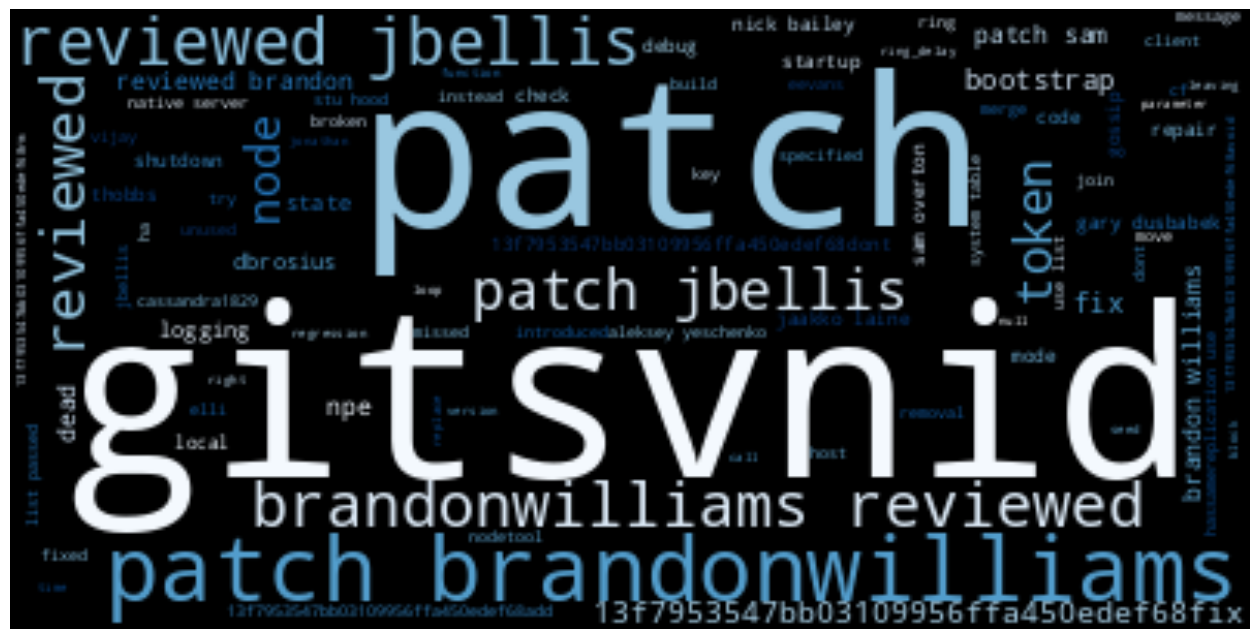

In [110]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap = 'Blues').generate(texto_limpo_msg_storagesevice)
plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Nuvem de palavras das "TODOs" das versões do source code do arquivo 'StorageService.java'

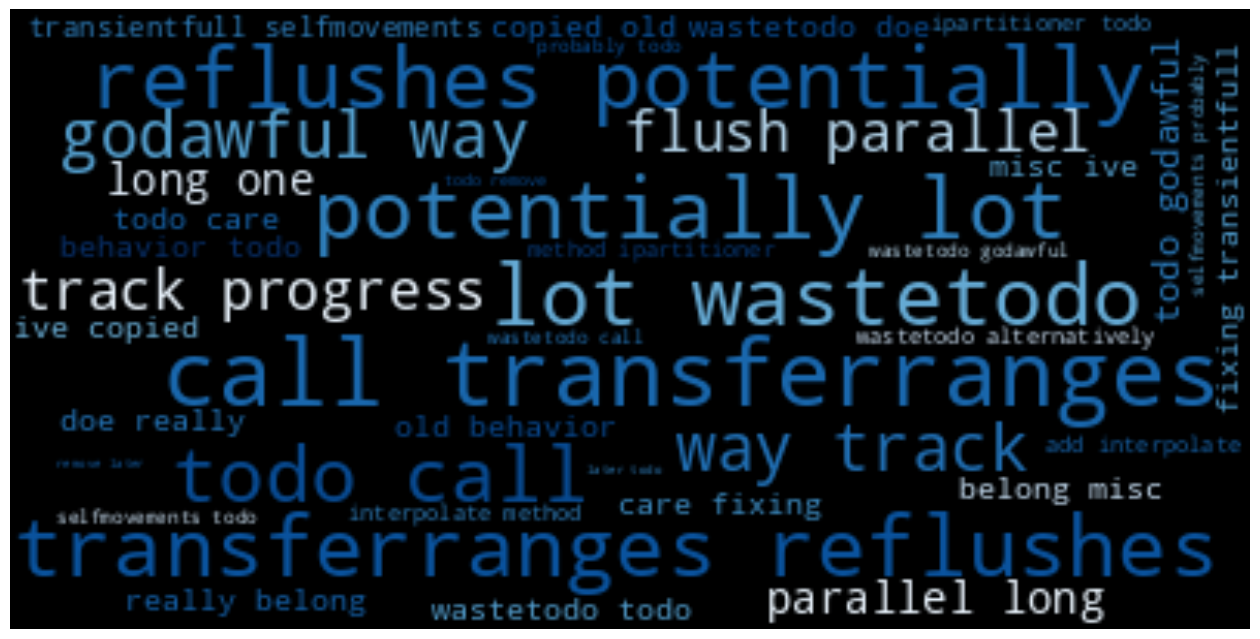

In [112]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='black', contour_width=2, contour_color='black', colormap = 'Blues').generate(texto_limpo_todos_storageservice)
plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()